# ex4: Neural Network Learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import minimize

In [2]:
inSize = 400
hiddenSize = 25
outSize = 10
num_labels = 10

## Part 1: Loading and Visualizing Data

In [3]:
data = loadmat('ex4/ex4data1.mat')
X = data['X']
y = data['y']

print(X.shape, y.shape)

(5000, 400) (5000, 1)


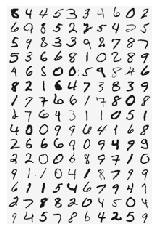

In [4]:
def displayData(X, rows=10, cols=10):
    w, h = 20, 20

    pic = np.zeros((h*rows, w*cols))
    idxs = np.random.choice(X.shape[0], rows * cols)

    i, j = 0, 0
    for idx in idxs:
        if i == cols:
            j += 1
            i = 0
        pic[j*h : (j+1)*h, i*w : (i+1)*w] = X[idx,:].reshape(w, h).T
        i += 1;
    plt.imshow(pic, cmap='Greys')
    plt.axis('off')
    plt.show()


displayData(X, 15, 10)

## Part 2: Loading Parameters

In [5]:
def flattenParams(Theta1, Theta2):
    return np.r_[Theta1.ravel(), Theta2.ravel()]

weights = loadmat('ex4/ex4weights.mat')
Theta1, Theta2 = weights['Theta1'], weights['Theta2']
nn_params = flattenParams(Theta1, Theta2)

print('Theta1:', Theta1.shape)
print('Theta2:', Theta2.shape)
print('nn_params:', nn_params.shape)

Theta1: (25, 401)
Theta2: (10, 26)
nn_params: (10285,)


## costFunction

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoidGradient(z):

    # =========== code here ============
    return np.multiply(sigmoid(z), 1 - sigmoid(z))
    # ==================================


def nnCostFunction(nn_params, inSize, hiddenSize, num_labels, X, y, lamb=0.):

    Theta1 = nn_params[:(inSize + 1) * hiddenSize].reshape(hiddenSize, inSize + 1)
    Theta2 = nn_params[(inSize + 1) * hiddenSize:].reshape(num_labels, hiddenSize + 1)

    m = X.shape[0]
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)


    # =========== code here ============

    # Part 1: Feedforward the neural network and return the cost
    X = np.c_[np.ones((m, 1)), X];
    label = np.zeros((m, num_labels))
    for i in np.arange(m):
        label[i, y[i] - 1] = 1
        # if y[i] == 10:
            # label[i, 0] = 1
        # else:
            # label[i, y[i]] = 1
    z2 = np.dot(X, Theta1.T)
    a2 = sigmoid(z2)
    a2 = np.c_[np.ones((m, 1)), a2]
    z3 = np.dot(a2, Theta2.T)
    a3 = sigmoid(z3)
    loss = -1/m * (np.multiply(label, np.log(a3)) + np.multiply(1 - label, np.log(1 - a3)))
    J = sum(loss.ravel())

    Theta1Sq = np.square(Theta1[:, 1:])
    Theta2Sq = np.square(Theta2[:, 1:])
    J = J + lamb / (2*m) * (sum(Theta1Sq.ravel()) + sum(Theta2Sq.ravel()))

    # Part 2: Implement the backpropagation algorithm to compute the gradients
    delta3 = a3 - label;
    Theta2_grad = 1/m * np.dot(delta3.T, a2)
    z2 = np.c_[np.ones((m, 1)), z2]
    delta2 = np.multiply(np.dot(delta3, Theta2), sigmoidGradient(z2))
    delta2 = delta2[:, 1:]
    Theta1_grad = 1/m * np.dot(delta2.T, X);

    # Part 3: Implement regularization with the cost function and gradients
    Theta1_grad[:, 1:] += lamb/m * Theta1[:, 1:]
    Theta2_grad[:, 1:] += lamb/m * Theta2[:, 1:]

    # ==================================


    grad = np.r_[Theta1_grad.ravel(), Theta2_grad.ravel()]

    return J, grad

## Part 3: Compute Cost (Feedforward)

In [7]:
lamb = 0
J, _ = nnCostFunction(nn_params, inSize, hiddenSize, num_labels, X, y, lamb)
print('cost is: ', J)

cost is:  0.287629165161321


## Part 4: Implement Regularization

In [8]:
lamb = 1
J, _ = nnCostFunction(nn_params, inSize, hiddenSize, num_labels, X, y, lamb)
print('cost is: ', J)

cost is:  0.3837698590909255


## Part 5: Sigmoid Gradient

In [9]:
z = np.array([-1, -0.5, 0, 0.5, 1])
g = sigmoidGradient(z)
print(g)

[0.19661193 0.23500371 0.25       0.23500371 0.19661193]


## Part 6: Initializing Parameters

In [10]:
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):
    W = np.zeros((L_out, 1 + L_in))
    
    # =========== code here ============
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
    # ==================================

    return W

In [11]:
initial_Theta1 = randInitializeWeights(inSize, hiddenSize)
initial_Theta2 = randInitializeWeights(hiddenSize, outSize)

initial_nn_params = flattenParams(initial_Theta1, initial_Theta2)

## Part 7: Implement Backpropagation (Gradient checking)

In [12]:
def checkNNGradients(nnCostFunction, lamb=0.):
    inSize = 3
    hiddenSize = 5
    num_labels = 3
    m = 5

    Theta1 = randInitializeWeights(inSize, hiddenSize)
    Theta2 = randInitializeWeights(hiddenSize, num_labels)
    nn_params = np.r_[Theta1.ravel(), Theta2.ravel()]
    
    X = np.random.randn(m, inSize)
    y = np.arange(1, 1 + m) % num_labels
    y = y.reshape((y.shape[0], 1))

    costFunc = lambda p: nnCostFunction(p, inSize, hiddenSize, num_labels, X, y, lamb)
    _, grad1 = costFunc(nn_params)

    e = 1e-4
    grad2 = np.zeros(nn_params.shape)
    for i in range(nn_params.size):
        params1 = nn_params.copy()
        params2 = nn_params.copy()
        params1[i] -= e
        params2[i] += e
        l1, _ = costFunc(params1)
        l2, _ = costFunc(params2)
        grad2[i] = (l2 - l1) / (2*e)

    print('checking gradients:')
    print(np.c_[grad1, grad2])


checkNNGradients(nnCostFunction)

checkNNGradients(nnCostFunction, lamb=3)

checking gradients:
[[-8.27181081e-03 -8.27181080e-03]
 [-8.75196232e-03 -8.75196231e-03]
 [ 1.14618789e-02  1.14618788e-02]
 [ 4.20931429e-04  4.20931430e-04]
 [ 3.94296889e-04  3.94296891e-04]
 [-9.50686945e-03 -9.50686944e-03]
 [ 1.21750556e-02  1.21750556e-02]
 [-1.86030775e-03 -1.86030775e-03]
 [-2.73562506e-04 -2.73562508e-04]
 [ 7.81012002e-03  7.81012000e-03]
 [-1.08977528e-02 -1.08977527e-02]
 [ 7.50949143e-03  7.50949142e-03]
 [-1.69450914e-03 -1.69450914e-03]
 [-1.62315493e-02 -1.62315493e-02]
 [ 2.12357145e-02  2.12357145e-02]
 [-5.12439575e-03 -5.12439574e-03]
 [ 6.19729543e-03  6.19729543e-03]
 [-2.69782227e-03 -2.69782228e-03]
 [ 1.59266297e-03  1.59266296e-03]
 [ 9.45388598e-03  9.45388597e-03]
 [ 7.06374252e-02  7.06374252e-02]
 [ 3.88961394e-02  3.88961394e-02]
 [ 3.47322876e-02  3.47322876e-02]
 [ 3.89072984e-02  3.89072984e-02]
 [ 3.98326952e-02  3.98326952e-02]
 [ 3.25074738e-02  3.25074738e-02]
 [ 1.22930107e-01  1.22930107e-01]
 [ 6.75359862e-02  6.75359862e-02]


## Part 8: Training NN

In [13]:
options = {'maxiter': 100}
lamb = 1.

costFunction = lambda p: nnCostFunction(p, inSize, hiddenSize, num_labels, X, y, lamb)

res = minimize(costFunction, initial_nn_params, jac=True, method='TNC', options=options)

nn_params = res.x

Theta1 = nn_params[:hiddenSize*(inSize + 1)].reshape(hiddenSize, inSize + 1)
Theta2 = nn_params[hiddenSize*(inSize + 1):].reshape(num_labels, hiddenSize + 1)

## Part 9: Visualize Weights

(25, 401)


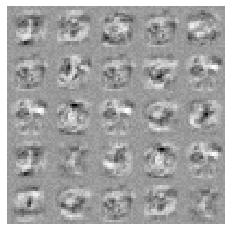

In [14]:
print(Theta1.shape)
displayData(Theta1[:, 1:], 5, 5)

## Part 10: Implement predict

In [15]:
def predict(Theta1, Theta2, X):
    m = X.shape[0]
    num_labels = Theta2.shape[0]
    X = np.c_[np.ones((m, 1)), X]
    h2 = sigmoid(np.dot(X, Theta1.T))
    h2 = np.c_[np.ones((m, 1)), h2]
    h3 = sigmoid(np.dot(h2, Theta2.T))
    p = np.argmax(h3, axis=1)
    return p + 1

p = predict(Theta1, Theta2, X)
acc = sum(p.ravel() == y.ravel()) / X.shape[0]

print('training acc: {}%'.format(acc * 100))

training acc: 96.56%
